In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

### Hyperparameters

In [8]:
batchsize = 32
n_class = 9
input_shape = (3,224,224)
device = 'cuda'

### Define and load dataset

Training, validation and test sets

In [2]:
import cv2
from PIL import Image
import os, os.path as osp

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

class FishDataloader():
    def __init__(self, set_dir, apply_mask=False) -> None:
        self.set_dir = set_dir
        self.apply_mask = apply_mask

        self.img_dir = osp.join(set_dir, 'images')
        self.mask_dir = osp.join(set_dir, 'masks')

        self.images, self.gts = [], []
        for img_path in list_join_dir(self.img_dir):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_basename = osp.basename(img_path)
            
            if self.apply_mask:
                mask_path = osp.join(self.mask_dir, img_basename)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.bitwise_and(img, img, mask=mask)

            self.images.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            self.gts.append(int(img_basename.split('.')[0].split('_')[0]))

    def __getitem__(self, idx):
        return self.images[idx], self.gts[idx]
    
    def __len__(self):
        return len(self.images)


train_set = FishDataloader('./dataset/project_dataset/train')
val_set = FishDataloader('./dataset/project_dataset/val')
test_set = FishDataloader('./dataset/project_dataset/test')

### Define transforms

In [3]:
from torchvision import transforms

val_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

train_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

### Define dataloaders

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

### Define CNN architecture

In [10]:
import torch
from torch import nn as nn
import math

class CMKNet(nn.Module):
    def __init__(self, dropout=0.5) -> None:
        super().__init__()
    
        self.dropout = dropout

        # input: 3, 224, 224
        self.col1 = nn.Sequential(
            self._conv_seq(3, 32, 3), # 32, 112, 112
            self._conv_seq(32, 64, 3), # 64, 56, 56
            self._conv_seq(64, 128, 3), # 128, 28, 28
        )

        self.col2 = nn.Sequential(
            self._conv_seq(3, 24, 5), # 32, 112, 112
            self._conv_seq(24, 48, 5), # 64, 56, 56
            self._conv_seq(48, 96, 5), # 128, 28, 28
        )

        self.fuse = self._conv_seq(128+96, 32, 1) # 32, 14, 14

        self.classifier = nn.Sequential(
            self._linear_seq(32*14*14, 1024, dropout),
            self._linear_seq(1024, 256, dropout),
            nn.Linear(256, n_class)
        )

    def forward(self, x):
        x1 = self.col1(x)
        x2 = self.col2(x)
        x = self.fuse(torch.cat((x1, x2), 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _fuse(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def _linear_seq(self, in_features, out_features, dropout):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
    def _conv_seq(self, in_channels, out_channels, kernel_size):
        "conv2d, batchnorm, relu, max pool"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels    
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()


### Create the model

In [11]:
from torchsummary import summary

model = CMKNet().to(device)
summary(model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 28, 28]         --
|    └─Sequential: 2-1                   [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─MaxPool2d: 3-4               [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-6             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-7                    [-1, 64, 112, 112]        --
|    |    └─MaxPool2d: 3-8               [-1, 64, 56, 56]          --
|    └─Sequential: 2-3                   [-1, 128, 28, 28]         --
|    |    └─Conv2d: 3-9                  [-1, 128, 56, 56]         73,728
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 28, 28]         --
|    └─Sequential: 2-1                   [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─MaxPool2d: 3-4               [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-6             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-7                    [-1, 64, 112, 112]        --
|    |    └─MaxPool2d: 3-8               [-1, 64, 56, 56]          --
|    └─Sequential: 2-3                   [-1, 128, 28, 28]         --
|    |    └─Conv2d: 3-9                  [-1, 128, 56, 56]         73,728
|    

### Define the loss function with L2 regularization

In [9]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

### Define optimizer and learning scheduler

In [10]:
optimizer    = optim.Adam(model.parameters(), lr=1e-5)
# gamma=0.1 is a multiplicative factor for lr decay at every epoch
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.1)
# gamma=0.1 is a multiplicative factor for lr decay at every step_size=number of epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

### Clean up memory if needed

In [11]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

### Define training and validation functions

In [12]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

### Train the model and report the results

In [13]:
# initializing variables
n_epochs = 100
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

EPOCH: 10.000	trn_loss: 0.392	trn_acc: 0.887	val_loss: 0.493	val_acc: 0.827	(21.42s - 192.79s remaining)
EPOCH: 20.000	trn_loss: 0.249	trn_acc: 0.929	val_loss: 0.379	val_acc: 0.850	(42.73s - 170.92s remaining)
EPOCH: 30.000	trn_loss: 0.244	trn_acc: 0.954	val_loss: 0.287	val_acc: 0.891	(64.04s - 149.42s remaining)
EPOCH: 40.000	trn_loss: 0.213	trn_acc: 0.942	val_loss: 0.295	val_acc: 0.866	(85.44s - 128.16s remaining)
EPOCH: 50.000	trn_loss: 0.188	trn_acc: 0.961	val_loss: 0.308	val_acc: 0.891	(106.72s - 106.72s remaining)
EPOCH: 60.000	trn_loss: 0.163	trn_acc: 0.988	val_loss: 0.322	val_acc: 0.858	(128.03s - 85.35s remaining)
EPOCH: 70.000	trn_loss: 0.203	trn_acc: 0.944	val_loss: 0.299	val_acc: 0.858	(149.77s - 64.19s remaining)
EPOCH: 80.000	trn_loss: 0.213	trn_acc: 0.944	val_loss: 0.308	val_acc: 0.866	(170.83s - 42.71s remaining)
EPOCH: 90.000	trn_loss: 0.204	trn_acc: 0.954	val_loss: 0.312	val_acc: 0.873	(192.06s - 21.34s remaining)
EPOCH: 100.000	trn_loss: 0.164	trn_acc: 0.950	val_loss

### Plot the results

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 11097.21it/s]


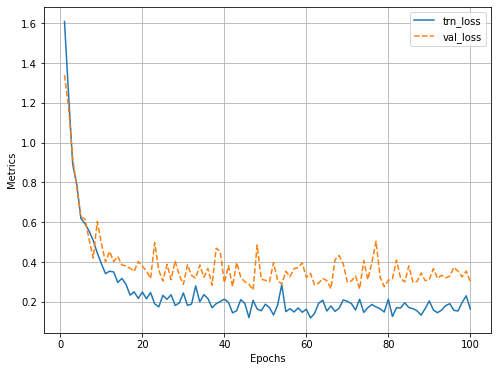

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 10461.69it/s]


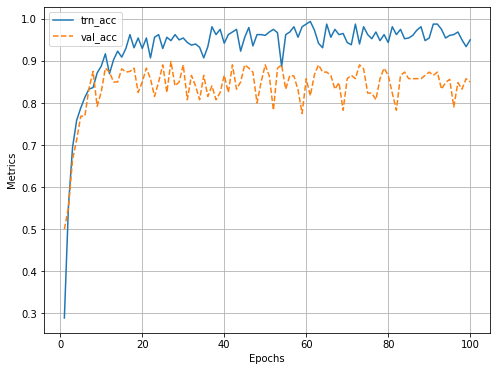

In [14]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [15]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.287021 Acc: 0.907670


### Save the model

In [16]:
torch.save(model.to('cpu').state_dict(), model_name)

#### Exercise: Play with optimizers, network architecture and hyperparameters to improve results without underfitting and overfitting. Note that you are using data augmentation, which might requires more epochs and lower learning rates for convergence. Verify preprocessing with no data augmentation and less training samples with data augmentation. 